In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score,r2_score,f1_score, confusion_matrix, recall_score,ConfusionMatrixDisplay,precision_score
import pandas_profiling as pp
from collections import Counter
import plotly.express as px
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import matplotlib as mpl
mpl.style.use('ggplot')
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
import warnings

warnings.filterwarnings('ignore')

# Functions we will need soon, just continue until we call it

In [2]:
def first_to_do (df,train=None):
    df.columns = [ re.sub(" ","_",i.lower()) for i in df.columns]
    strings = [i for i in df.columns if(df[i].dtype=="O")]
    count = [Counter(df[i]) for i in strings ]
    print("Done with columns!!")
    if train=="count":
        print(f"\nValues counts for each class:\n{Counter(df.iloc[:,-1])}") 
    print(f"\nNumber of duplicates: {df.duplicated().sum()}\n\
\nNumber of null values in each column: \n{(df.isna().sum())}\n\
\nShape of data: {df.shape}\n\nNames of object columns: {strings}, and their number: {len(strings)}\
\n\nValue count for strings: {count}")

    return df

def check_correlation(df,class_col):
    fig = px.bar(df.corr()[class_col])
    fig.show()
    
def inplace_lb_encoding(df,lst):
    lb = LabelEncoder()
    for i in lst:
        df[i] = lb.fit_transform(df[i]).astype(int)
        
def testing_various_clf(X,y):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
    ones = [i for i in y_train if i==1]
    print(f"model trained on: {len(ones)} of ones, while: {(len(y_train)-len(ones))} of zeros")
    modls = dict()
    models = [("logistic Regression",LogisticRegression()),("Decision Tree",DecisionTreeClassifier()),("Random Forest",RandomForestClassifier())]
    for name,model in models:
        print(f"--------------------------------------------------------\n{name}\n--------------------------------------------------------")
        modls[name] = [cross_val_score(model,X,y,cv=10).mean()]
        y_pred = model.fit(X_train,y_train).predict(X_test)
        print(f"Recall score: {round(recall_score(y_test,y_pred),3)}, precision score: {round(precision_score(y_test,y_pred),3)}, f1-score: {round(f1_score(y_test,y_pred),3)}\n")
        print(pd.DataFrame(confusion_matrix(y_test,y_pred)))
        
        print(f"number of unique predicted classes: {np.unique(y_pred)}")
    return pd.DataFrame(modls)

def overampling_split_data (X,y):
    print("Check if data is splitted or not, dont ignore me -_-\n")
    # concatenating trainnig set again 
    concat_ = pd.concat([X,y],axis=1)
    # separating majority, and minority class
    zeros = concat_[concat_["response"]==0 ]
    ones = concat_[concat_["response"]==1 ]
    oversampled = resample(ones,n_samples=len(zeros),random_state=42)
    oversampled_data = pd.concat([zeros,oversampled])
    print(f"imbalanced class after oversampling:\n{oversampled_data['response'].value_counts()}\n")
    X_over = oversampled_data.drop('response',axis=1)
    y_over = oversampled_data['response']
    sns.countplot(y_over)
    plt.show()
    return (testing_various_clf(X_over,y_over),oversampled_data)

def undersampling_split_data (X,y):
    print("Check if data is splitted or not, dont ignore me -_-\n")
    # concatenating trainnig set again 
    concat_ = pd.concat([X,y],axis=1)
    # separating majority, and minority class
    zeros = concat_[concat_["response"]==0 ]
    ones = concat_[concat_["response"]==1 ]
    undersampled = resample(zeros,replace=False,n_samples=len(ones),random_state=42)
    undersampled_data = pd.concat([ones,undersampled])
    print(f"imbalanced class after undersampling:\n{undersampled_data['response'].value_counts()}\n")
    X_under = undersampled_data.drop('response',axis=1)
    y_under = undersampled_data['response']
    sns.countplot(y_under)
    plt.show()
    return (testing_various_clf(X_under,y_under),undersampled_data)

In [3]:
df = pd.read_csv("train.csv")
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
df = first_to_do(df,'count')

Done with columns!!

Values counts for each class:
Counter({0: 334399, 1: 46710})

Number of duplicates: 0

Number of null values in each column: 
id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

Shape of data: (381109, 12)

Names of object columns: ['gender', 'vehicle_age', 'vehicle_damage'], and their number: 3

Value count for strings: [Counter({'Male': 206089, 'Female': 175020}), Counter({'1-2 Year': 200316, '< 1 Year': 164786, '> 2 Years': 16007}), Counter({'Yes': 192413, 'No': 188696})]


We have imbalanced data as number of zeros in target class: 3334399, while ones: 46710

In [5]:
df['vehicle_age'] = df['vehicle_age'].replace({'1-2 Year':1 ,'< 1 Year' : 0 , '> 2 Years': 2})
inplace_lb_encoding(df,['gender','vehicle_damage'])

In [6]:
first_to_do(df)

Done with columns!!

Number of duplicates: 0

Number of null values in each column: 
id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

Shape of data: (381109, 12)

Names of object columns: [], and their number: 0

Value count for strings: []


,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,1,44,1,28.0,0,2,1,40454.0,26.0,217,1
1,2,1,76,1,3.0,0,1,0,33536.0,26.0,183,0
2,3,1,47,1,28.0,0,2,1,38294.0,26.0,27,1
3,4,1,21,1,11.0,1,0,0,28619.0,152.0,203,0
4,5,0,29,1,41.0,1,0,0,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,1,74,1,26.0,1,1,0,30170.0,26.0,88,0
381105,381106,1,30,1,37.0,1,0,0,40016.0,152.0,131,0
381106,381107,1,21,1,30.0,1,0,0,35118.0,160.0,161,0
381107,381108,0,68,1,14.0,0,2,1,44617.0,124.0,74,0


# After dealing with categorical features, lets see correlation with target value

In [7]:
check_correlation(df,'response')

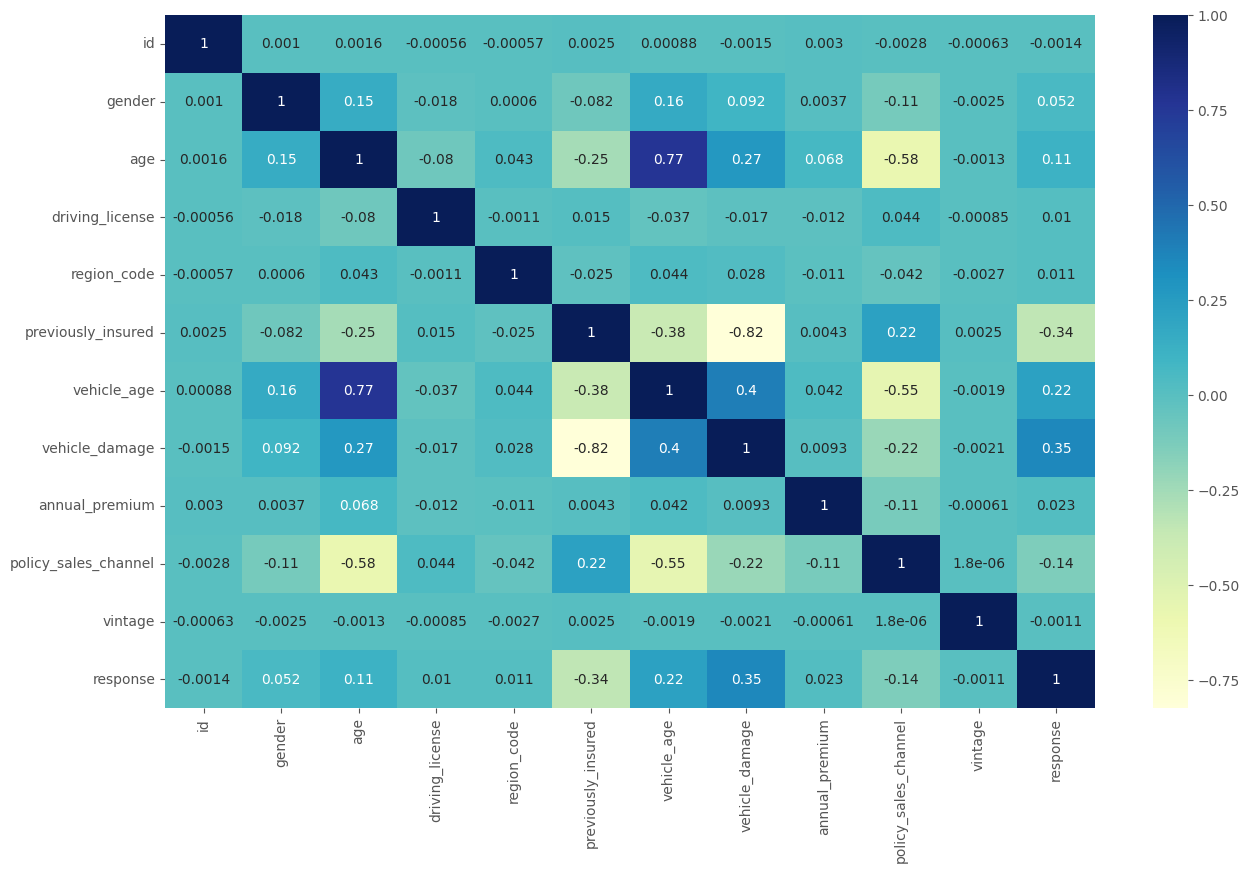

In [8]:
fig,ax = plt.subplots(figsize=(15,9))
sns.heatmap(df.corr(),annot=True,cmap="YlGnBu")
plt.show()

I will drop any column with correlation less than 20 % 

# Fitting data without handling imbalanced data

In [9]:
X = df[['previously_insured','vehicle_damage','vehicle_age']]
y = df['response']
print(X)

        previously_insured  vehicle_damage  vehicle_age
0                        0               1            2
1                        0               0            1
2                        0               1            2
3                        1               0            0
4                        1               0            0
...                    ...             ...          ...
381104                   1               0            1
381105                   1               0            0
381106                   1               0            0
381107                   0               1            2
381108                   0               0            1

[381109 rows x 3 columns]


Data doesn't need any scaling

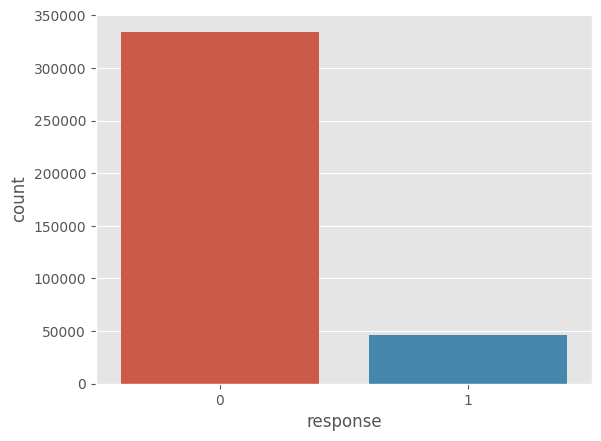

In [10]:
sns.countplot(df['response'])
plt.show()

In [11]:
modls = testing_various_clf(X,y)

model trained on: 32572 of ones, while: 234204 of zeros
--------------------------------------------------------
logistic Regression
--------------------------------------------------------
Recall score: 0.0, precision score: 0.0, f1-score: 0.0

        0  1
0  100195  0
1   14138  0
number of unique predicted classes: [0]
--------------------------------------------------------
Decision Tree
--------------------------------------------------------
Recall score: 0.0, precision score: 0.0, f1-score: 0.0

        0  1
0  100195  0
1   14138  0
number of unique predicted classes: [0]
--------------------------------------------------------
Random Forest
--------------------------------------------------------
Recall score: 0.0, precision score: 0.0, f1-score: 0.0

        0  1
0  100195  0
1   14138  0
number of unique predicted classes: [0]


So, as we see in the output of the prevoius cell the imbalanced class made the model to overfit on the larger class(0), and predicted nothing true of smaller class (1)

In [12]:
modls

,logistic Regression,Decision Tree,Random Forest
0,0.877437,0.877437,0.877437


# Now we will handle imbalanced class, by 2 different techniques 
# 1- Oversampling minority class

Check if data is splitted or not, dont ignore me -_-

imbalanced class after oversampling:
0    334399
1    334399
Name: response, dtype: int64



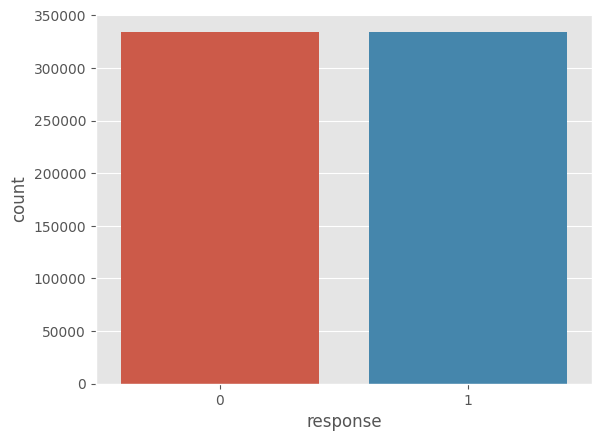

model trained on: 233854 of ones, while: 234304 of zeros
--------------------------------------------------------
logistic Regression
--------------------------------------------------------
Recall score: 0.977, precision score: 0.705, f1-score: 0.819

       0      1
0  58978  41117
1   2302  98243
number of unique predicted classes: [0 1]
--------------------------------------------------------
Decision Tree
--------------------------------------------------------
Recall score: 0.977, precision score: 0.705, f1-score: 0.819

       0      1
0  58978  41117
1   2302  98243
number of unique predicted classes: [0 1]
--------------------------------------------------------
Random Forest
--------------------------------------------------------
Recall score: 0.977, precision score: 0.705, f1-score: 0.819

       0      1
0  58978  41117
1   2302  98243
number of unique predicted classes: [0 1]


In [13]:
modls,oversampled_data = overampling_split_data(X,y)

In [14]:
oversampled_data.shape

(668798, 4)

The model Accuracy has decreased but can predict both classes

# 2- Undersampling majority class

Check if data is splitted or not, dont ignore me -_-

imbalanced class after undersampling:
1    46710
0    46710
Name: response, dtype: int64



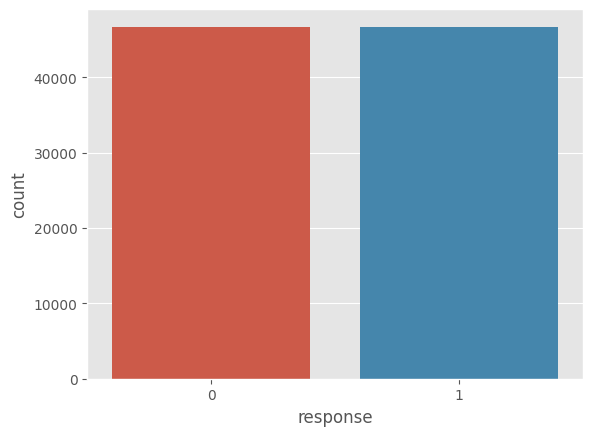

model trained on: 32697 of ones, while: 32697 of zeros
--------------------------------------------------------
logistic Regression
--------------------------------------------------------
Recall score: 0.976, precision score: 0.704, f1-score: 0.818

      0      1
0  8256   5757
1   334  13679
number of unique predicted classes: [0 1]
--------------------------------------------------------
Decision Tree
--------------------------------------------------------
Recall score: 0.976, precision score: 0.704, f1-score: 0.818

      0      1
0  8256   5757
1   334  13679
number of unique predicted classes: [0 1]
--------------------------------------------------------
Random Forest
--------------------------------------------------------
Recall score: 0.976, precision score: 0.704, f1-score: 0.818

      0      1
0  8256   5757
1   334  13679
number of unique predicted classes: [0 1]


In [15]:
modls,undersampled_data = undersampling_split_data(X,y)

In [16]:
undersampled_data.shape

(93420, 4)

# Testing Set

In [17]:
df2 = pd.read_csv("test.csv")
df2.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [18]:
df2 = first_to_do(df2)

Done with columns!!

Number of duplicates: 0

Number of null values in each column: 
id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
dtype: int64

Shape of data: (127037, 11)

Names of object columns: ['gender', 'vehicle_age', 'vehicle_damage'], and their number: 3

Value count for strings: [Counter({'Male': 68236, 'Female': 58801}), Counter({'1-2 Year': 66699, '< 1 Year': 55019, '> 2 Years': 5319}), Counter({'Yes': 63835, 'No': 63202})]


In [19]:
df2['vehicle_age'] = df2['vehicle_age'].replace({'1-2 Year':1 ,'< 1 Year' : 0 , '> 2 Years': 2})
inplace_lb_encoding(df2,['gender','vehicle_damage'])

# Now we can use oversampled data or undersampled data as both of them almost the same accuracy

I will choose the undersampled data as it is smaller and faster to fit, and will be better in tuning its parameter, and both of them are great <br>
I will choose the logistic regression as the algorithms act the same too ^_^

In [20]:
X_train = undersampled_data.drop('response', axis=1)
y_train = undersampled_data['response']
X_test = df2[['previously_insured','vehicle_damage','vehicle_age']]

In [21]:
clf = LogisticRegression()
y_pred = clf.fit(X_train,y_train).predict(X_test)

In [22]:
df3 = pd.DataFrame({'id':df2['id'],'Response':y_pred})
df3.head()

,id,Response
0,381110,0
1,381111,1
2,381112,1
3,381113,0
4,381114,0


# After predicting there is no overfitting on one class as before both classes are approximatly the same, as we see in the plot

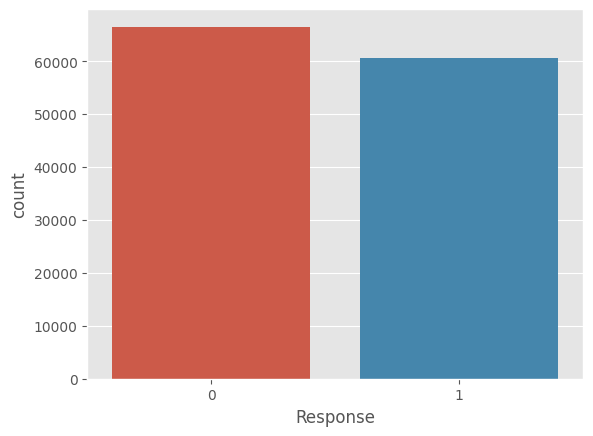

In [23]:
sns.countplot(df3['Response'])
plt.show()

In [24]:
df3.to_csv("Dont forget the upvote ^_^.csv")